In [26]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [27]:
pd.set_option('display.max_columns', None)

In [28]:
df_ny = pd.read_parquet('../data/ML_Data/NY',  engine='pyarrow')
df_fl = pd.read_parquet('../data/ML_Data/FL',  engine='pyarrow')
df_ca = pd.read_parquet('../data/ML_Data/CA', engine='pyarrow')
df_tx =pd.read_parquet('../data/ML_Data/TX', engine='pyarrow')

In [29]:
df_ny.head()

,respondent,value,year,month,days,hour,quarter,dayofyear,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,Adj Close,Adj_Close_30D_lag,Adj_Close_60D_lag,"conditions_Freezing Drizzle/Freezing Rain, Ice, Overcast","conditions_Freezing Drizzle/Freezing Rain, Overcast","conditions_Ice, Overcast",conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Ice, Overcast","conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Overcast","conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Fog","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_clear-night,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_snow,icon_wind,Holiday_Christmas Day,Holiday_Christmas Day (substitute),Holiday_Christmas Eve,Holiday_Cinco de Mayo,Holiday_Columbus Day,Holiday_Day After Christmas Day,Holiday_Easter Monday,Holiday_Easter Sunday,Holiday_Election Day,Holiday_Election Day (General Election),Holiday_Father's Day,Holiday_Flag Day,Holiday_Halloween,Holiday_Inauguration Day,Holiday_Independence Day,Holiday_Independence Day (substitute),Holiday_Juneteenth,Holiday_Juneteenth (substitute),Holiday_Labor Day,Holiday_Martin Luther King Jr. Day,Holiday_Memorial Day,Holiday_Mother's Day,Holiday_New Year's Day,Holiday_New Year's Day (substitute),Holiday_New Year's Eve,Holiday_Presidents' Day,Holiday_St. Patrick's Day,Holiday_Super Tuesday,Holiday_Tax Day,Holiday_Thanksgiving Day,Holiday_Valentine's Day,Holiday_Veterans Day,Holiday_Veterans Day (substitute),Energy_30D_AVG
period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31 05:00:00,New York Independent System Operator,20324.0,2015,7,6,5,3,212,74.9,74.9,62.4,65.11,0.0,0,0.0,0.0,5.0,306.0,1010.6,75.0,9.9,0.8,0.0,49.811298,49.811298,49.811298,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21258.863889
2015-07-31 06:00:00,New York Independent System Operator,19228.0,2015,7,6,6,3,212,73.5,73.5,61.7,66.49,0.0,0,0.0,0.0,5.0,307.0,1010.9,10.5,9.9,79.8,1.0,49.811298,49.811298,49.811298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21263.309722
2015-07-31 07:00:00,New York Independent System Operator,18417.0,2015,7,6,7,3,212,73.7,73.7,61.6,66.07,0.0,0,0.0,0.0,2.7,326.0,1011.3,10.5,9.9,261.3,3.0,49.811298,49.811298,49.811298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21267.304167
2015-07-31 08:00:00,New York Independent System Operator,17863.0,2015,7,6,8,3,212,75.5,75.5,59.6,57.85,0.0,0,0.0,0.0,4.6,299.0,1011.6,14.1,9.9,458.0,5.0,49.811298,49.811298,49.811298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21270.887500
2015-07-31 09:00:00,New York Independent System Operator,17689.0,2015,7,6,9,3,212,77.7,77.7,59.6,53.63,0.0,0,0.0,0.0,4.1,299.0,1011.7,10.5,9.9,641.0,6.0,49.811298,49.811298,49.811298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21274.200000


In [30]:
TARGET = 'value'
FEATURES = df_ny.columns[2:]

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
def rand_tree_train(df, week):
    tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
    df = df.sort_index()
    fold = 0
    preds = []
    scores_rmse = []
    scores_mae = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        regr = RandomForestRegressor(n_estimators=10,
                            max_depth=10,
                            random_state=42,
                            n_jobs=-1,
                            min_samples_split=4,
                            max_features=9
                            )
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        preds.append(y_pred)
        score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores_rmse.append(score_rmse)
        scores_mae.append(mean_absolute_error(y_test,y_pred))
    print(f'Score across folds {np.mean(scores_rmse):0.4f}')
    print(f'Fold scores:{scores_rmse}')
    print(f'Score across folds {np.mean(scores_mae):0.4f}')
    print(f'Fold scores:{scores_mae}')
    if week is None:
        week = ['03-01-2023', '03-07-2023']
    test['prediction'] = regr.predict(X_test)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = df[['value']].plot(figsize=(15, 6))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['Actual', 'Predicted'],loc='upper right')
    ax.set_title('Actual VS. Predicted')
    plt.show()
    
    ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
    .plot(figsize=(15, 6), title='Week Of Data')
    df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
        .plot()
    plt.legend(['Actual','Predicted'],loc='upper right')
    plt.show()
    # print(df.head())
    return regr, X_test, test

In [33]:
# def create_graphs(df, X_test,test, week=None):
#     if week is None:
#         week = ['12-20-2022', '12-27-2022']
#     test['prediction'] = regr.predict(X_test)
#     df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
#     ax = df[['value']].plot(figsize=(15, 6))
#     df['prediction'].plot(ax=ax, style='.')
#     plt.legend(['Actual', 'Predicted'],loc='upper right')
#     ax.set_title('Actual VS. Predicted')
#     plt.show()


#     ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
#     .plot(figsize=(15, 6), title='Week Of Data')
#     df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
#         .plot()
#     plt.legend(['Actual','Predicted'],loc='upper right')
#     plt.show()

In [34]:
def create_importance(regr):
    fi = pd.DataFrame(data = regr.feature_importances_[:15],
    index = regr.feature_names_in_[:15],
    columns = ['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance', layout='constrained', figsize=(15, 15))
    plt.show()

In [35]:
def run_model(df, week_list=None):    
    if week_list == None:
        week = ['03-01-2023', '03-07-2023']
    else:
        week = week_list
    regr, X_test, test = rand_tree_train(df, week)
    # create_graphs(df,X_test=X_test, test=test, week=week)
    create_importance(regr)

Score across folds 1573.6694
Fold scores:[1622.9262209778458, 1710.3280364019824, 1387.7538428911364]
Score across folds 1266.0151
Fold scores:[1325.6193821837435, 1353.6751295505164, 1118.7507364422481]


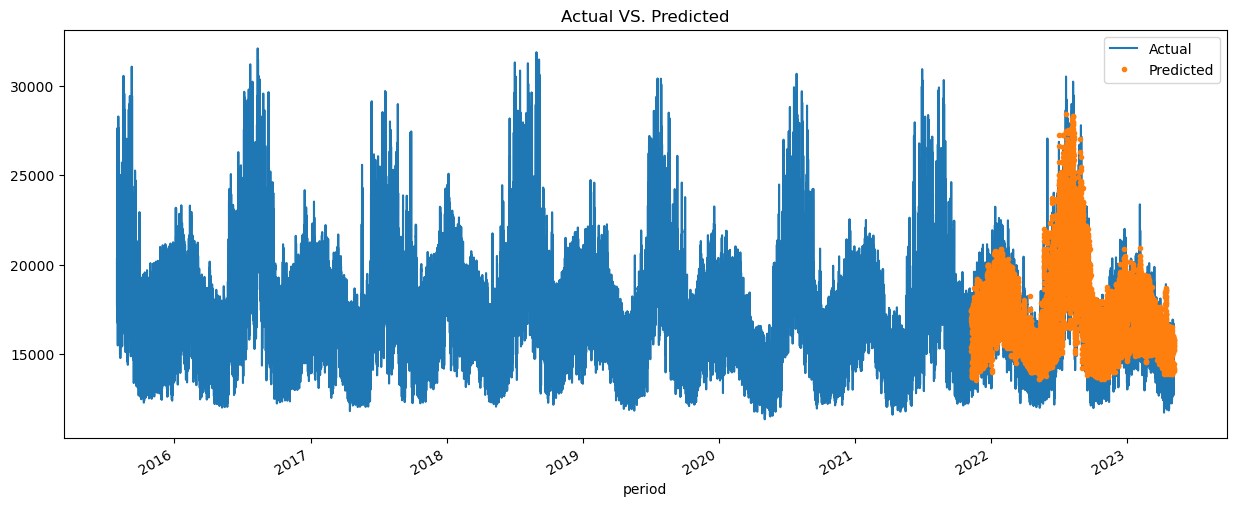

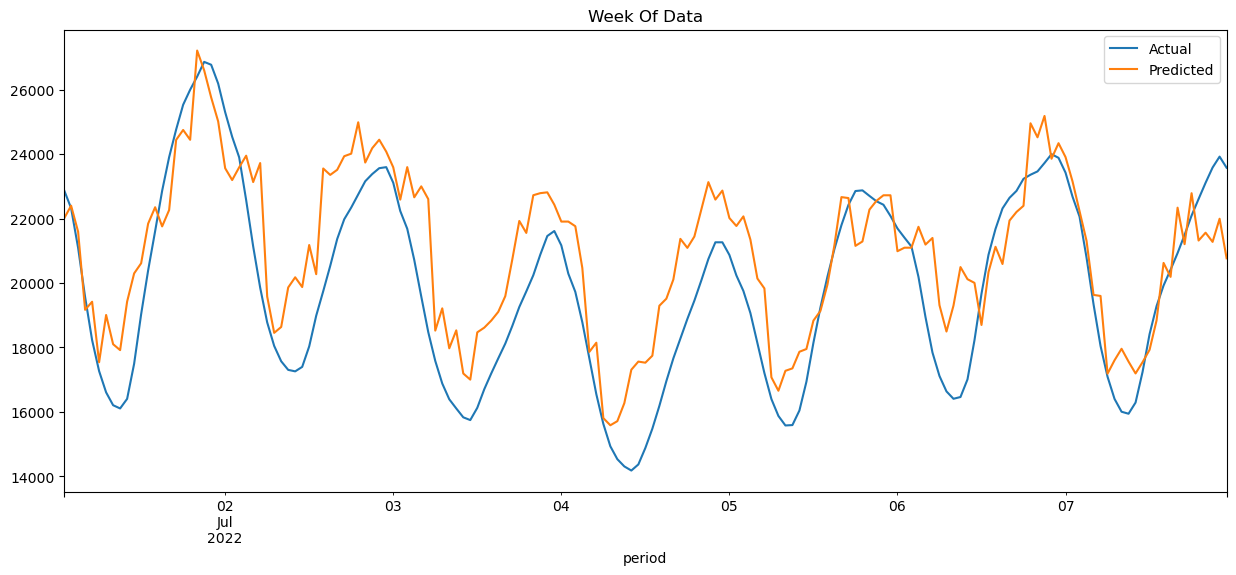

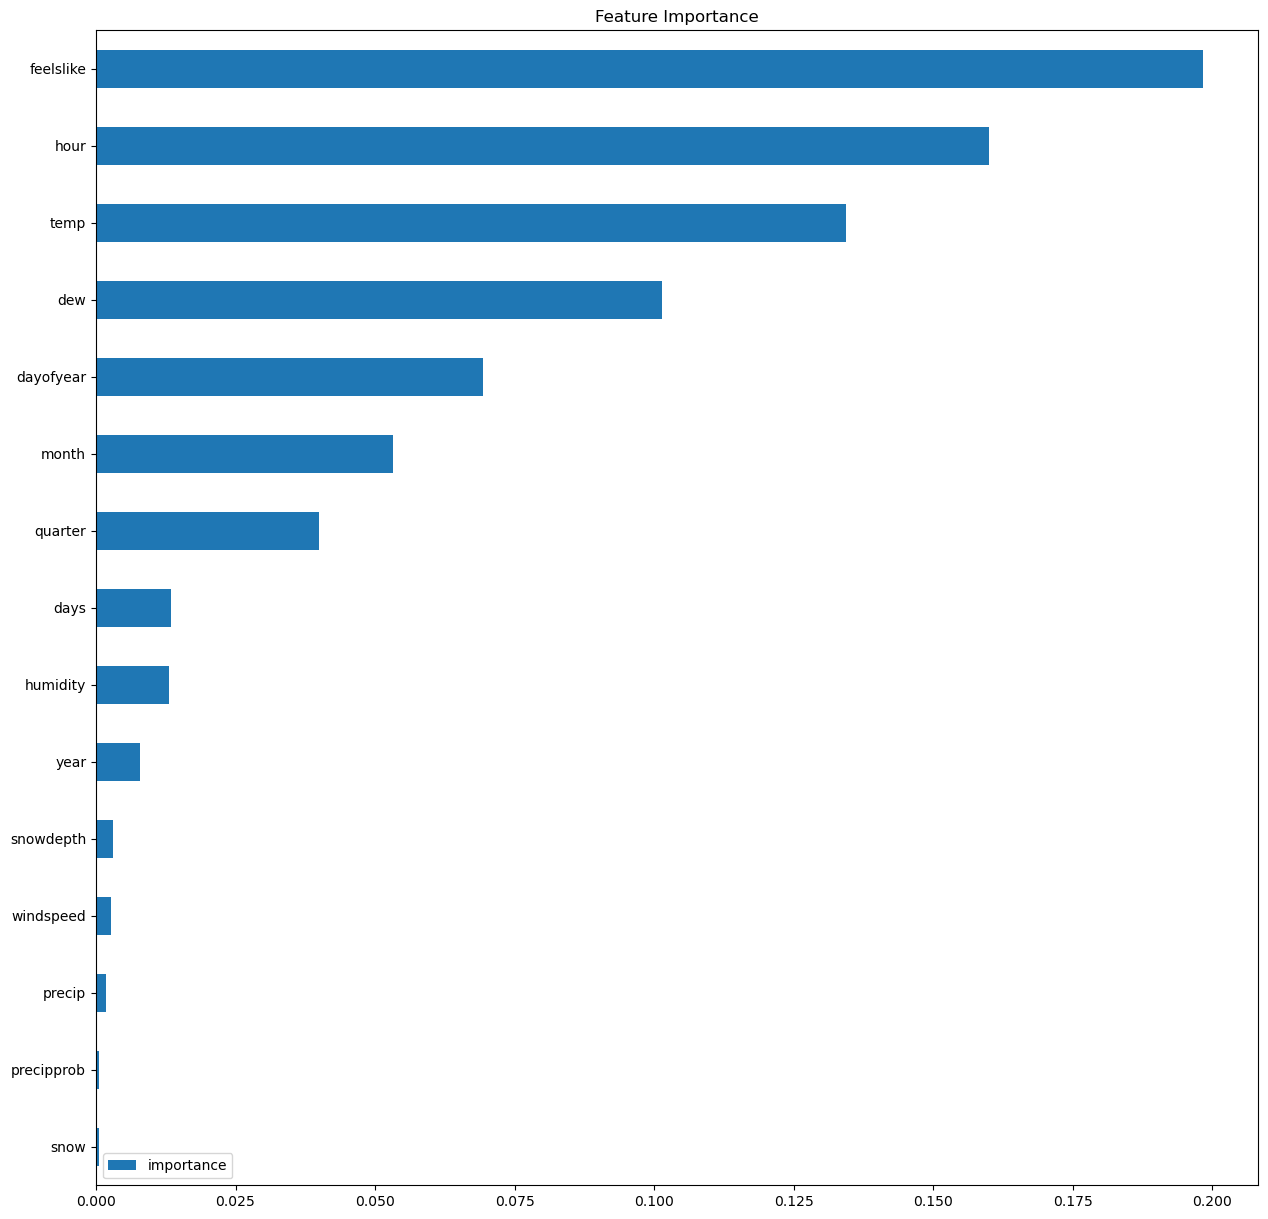

In [38]:
mod_ny = run_model(df_ny, ['07-01-2022', '07-08-2022'])

Score across folds 6063.5474
Fold scores:[5585.2407962115885, 5605.024720505536, 7000.37671100389]
Score across folds 4538.0647
Fold scores:[4156.6623662189, 4230.392940866487, 5227.13875020087]


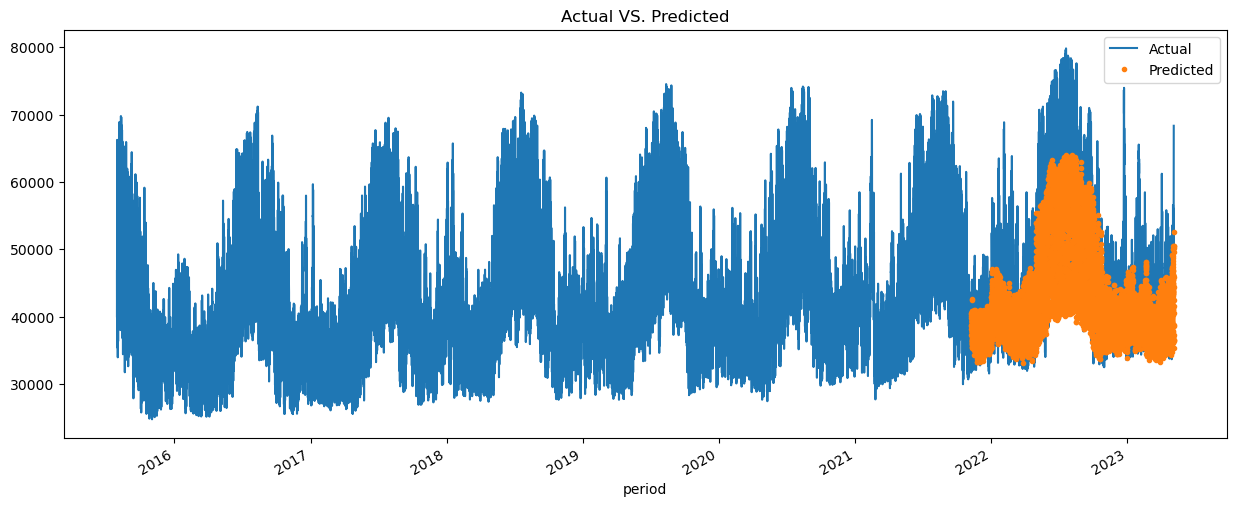

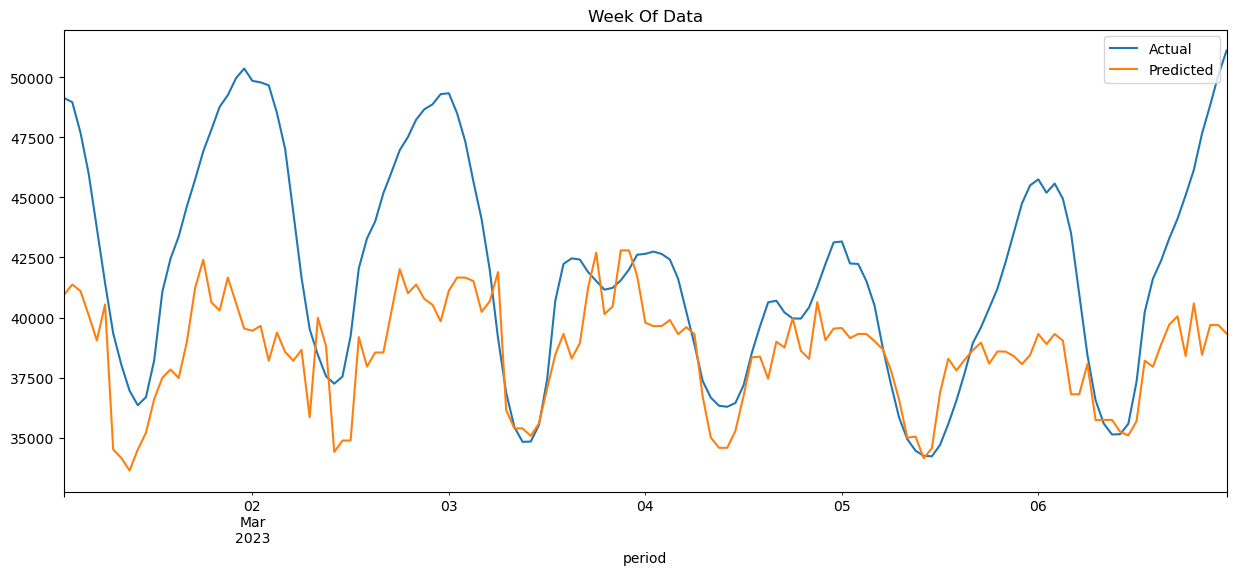

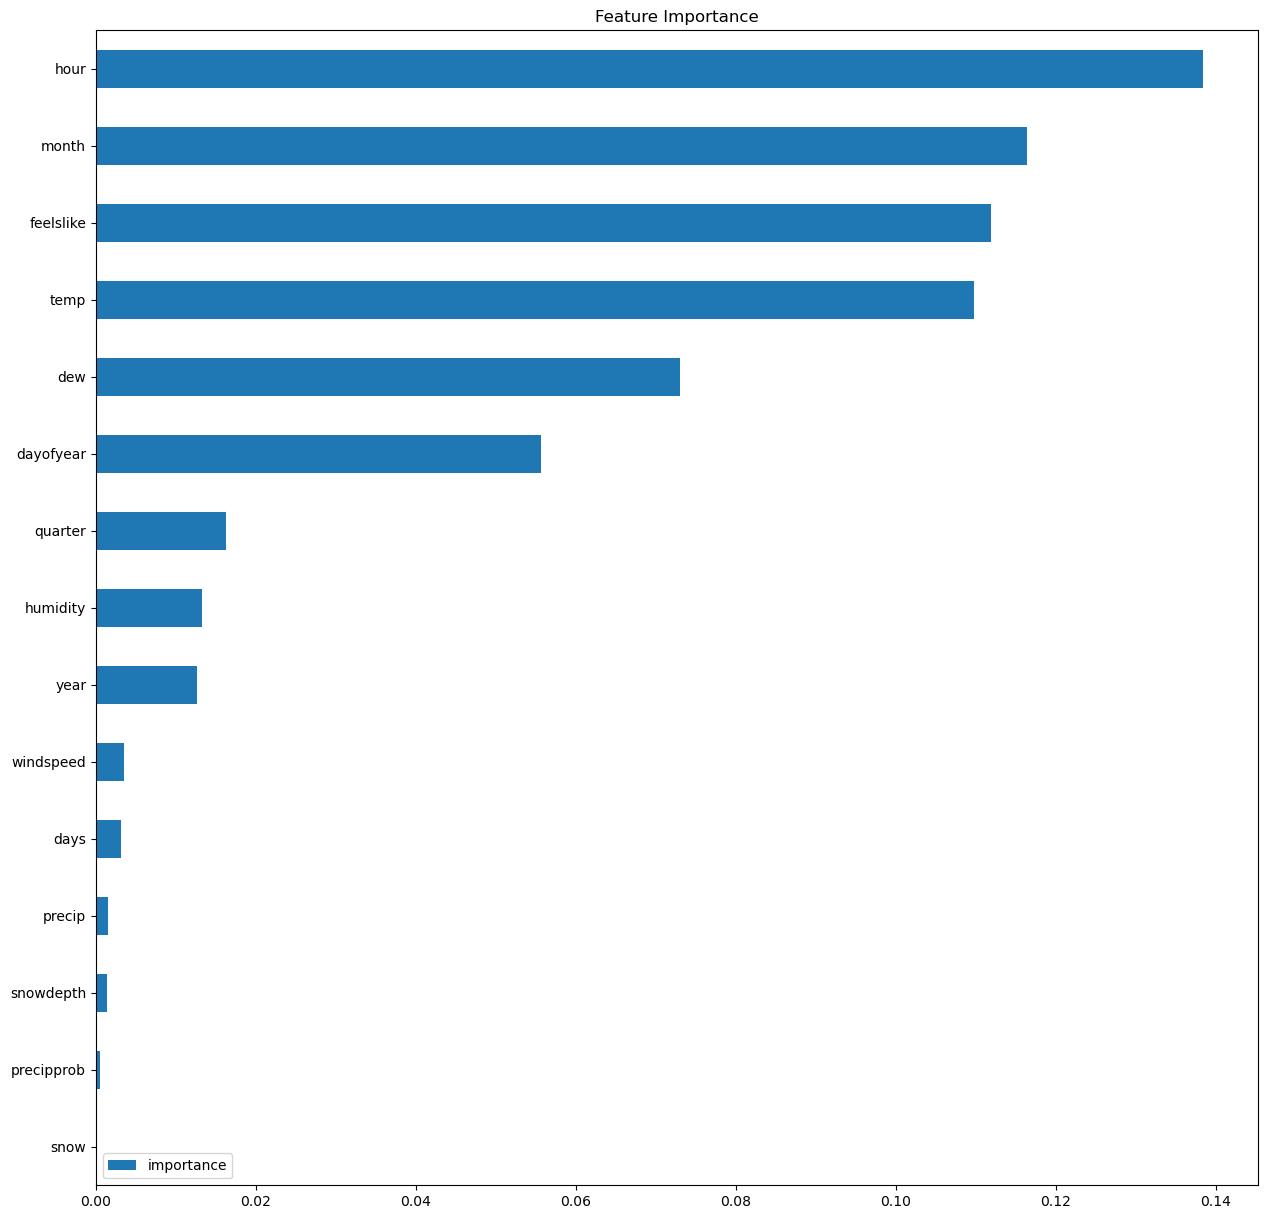

In [39]:
mod_tx = run_model(df_tx)